# Explore genes - TF

Steps includes:

* calculation of the TF-target distances 
* TF-target top-50 table (compared with SCENIC)
* TF annotation on UMAP-plots
* extraction of gene modules based on TF-target
* cross-species target-set intersection of homologous TFs


In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import scanpy as sc
from scipy import sparse
from scipy.special import softmax

import networkx as nx
import torch

In [2]:
import sys
sys.path.append('../')

import came
from came import pipeline, pp, pl

Using backend: pytorch


## Load CAME results

In [3]:
# the result directory
_resdn = "testis-('testis_human', 'testis_monkey')(08-01 00.01.46)" # spg
# _resdn = "testis-('testis_human', 'testis_mouse')(08-01 00.53.55)"
# _resdn = "('Lake_2018', 'Tasic18')-(08-15 11.03.05)"

came_resdir = Path(f"../_case_res/{_resdn}")

sp1, sp2 = 'human', 'macaque'

dpair, model = came.load_dpair_and_model(came_resdir)
predictor = came.Predictor.load(came_resdir / 'predictor.json')

# the feature dict and the heterogrnrous cell-gene graph
feat_dict = dpair.get_feature_dict(scale=True)
g = dpair.get_whole_net()

# reference and query sample-ids / gene-ids
obs_ids1, obs_ids2 = dpair.obs_ids1, dpair.obs_ids2
var_ids1, var_ids2 = dpair.var_ids1, dpair.var_ids2

classes = predictor.classes

[*] Setting dataset names:
	0-->testis_human
	1-->testis_monkey
[*] Setting aligned features for observation nodes (self._features)
[*] Setting un-aligned features (`self._ov_adjs`) for making links connecting observation and variable nodes
[*] Setting adjacent matrix connecting variables from these 2 datasets (`self._vv_adj`)
Index(['nGene', 'nUMI', 'orig.ident', 'percent.mito', 'indiv', 'CellType',
       'percent.x', 'percent.y', 'percent.autosome', 'GiniAll', 'GiniNon0',
       'cell_ontology_class'],
      dtype='object')
Index(['nGene', 'nUMI', 'orig.ident', 'percent.x', 'percent.y', 'percent.mito',
       'percent.autosome', 'indiv', 'GiniAll', 'GiniNon0', 'CellType',
       'cell_ontology_class', 'clust_lbs'],
      dtype='object')
-------------------- Summary of the DGL-Heterograph --------------------
Graph(num_nodes={'cell': 29591, 'gene': 723},
      num_edges={('cell', 'express', 'gene'): 4709328, ('cell', 'self_loop_cell', 'cell'): 29591, ('cell', 'similar_to', 'cell'): 2

## Compute / save / reload the hidden states

In [4]:
# all hidden states
hidden_list = came.model.get_all_hidden_states(model, feat_dict, g)

In [5]:
hidden_list[0]['cell'].shape, hidden_list[0]['gene'].shape

((29591, 128), (723, 128))

save the hidden states into .h5 file:

In [6]:
came.save_hidden_states(hidden_list, came_resdir / 'hidden_list.h5')

re-load the hidden states from the .h5 file:

In [7]:
hidden_list = came.load_hidden_states(came_resdir / 'hidden_list.h5')
# hidden_list[0]

### Define functions for computing target-intersectioins

In [23]:
def make_name_map(
    df_varmap, 
    icol_index=0, icol_val=1, 
    col_index=None, col_val=None
):
    if col_index is None:
        col_index = df_varmap.columns[icol_index]
    var_map = df_varmap.set_index(col_index, drop=False)
    
    if col_val is None:
        var_map = var_map.iloc[:, icol_val].to_dict()
    else:
        var_map = var_map[icol_val].to_dict()
    return var_map


def intersect(set1, set2, name_map=None):
    """ `name_map` maps names in set1 to names in set2"""
    if name_map is not None:
        set1 = set([name_map.get(x, None) for x in set1])

    return set(set1).intersection(set2)


def common_targets(
    df_tf_targets1: pd.DataFrame,
    df_tf_targets2: pd.DataFrame,
    col_target='knn',
    name_map=None,
):
    records = []
    for tf1 in df_tf_targets1.index:
        if name_map is not None:
            tf2 = name_map.get(tf1, None)
        else:
            tf2 = tf1
        if tf2 in df_tf_targets2.index:
            common = intersect(
                df_tf_targets1.loc[tf1, col_target], 
                df_tf_targets2.loc[tf2, col_target], 
                name_map,
            )
            n = len(common) - 1
            records.append(dict(tf1=tf1, tf2=tf2, n_common=n, common_set=common))
        else:
            common = None
            n = 0
        # print(f'{(tf1, tf2)}\tn={n}:\t{common}')

    return pd.DataFrame(records)


In [ ]:
df_varmap = pd.read_csv(f'../came/sample_data/gene_matches_1v1_{sp1}2{sp2}.csv')
df_varmap = df_varmap.iloc[:, : 2]

name_map = make_name_map(df_varmap)

## Get TF infomation

In [8]:
tfdir = Path('/Users/xingyan/Data/TF')

human_tf = pd.read_csv(tfdir / 'fantomTFs-human.csv')['Symbol'].tolist()
mouse_tf = pd.read_csv(tfdir / 'fantomTFs-mouse.csv')['Symbol'].tolist()

tf_dict = {
    'human': human_tf,
    'mouse': mouse_tf
}

all_tflist1 = tf_dict.get(sp1, human_tf)
all_tflist2 = tf_dict.get(sp2, human_tf)

In [9]:
# node-ids and names of TF
tfids1, tfnames1 = dpair.get_vnode_ids_by_name(all_tflist1, 0, rm_unseen=True)
tfids2, tfnames2 = dpair.get_vnode_ids_by_name(all_tflist2, 1, rm_unseen=True)

len(tfnames1), len(tfnames2)

(15, 15)

In [10]:
ilayer = [0, -1][0]
metric = 'cosine'
algorithm='brute'
k = 30

# get hidden states
h_gene = hidden_list[ilayer]['gene']

df_tf_targets1, df_tf_targets2 = came.ana.tf_cross_knn(
        h_gene, dpair, all_tflist1, all_tflist2,
    )

In [11]:
df_tf_targets1.to_csv(came_resdir / f'tf_targets1_top{k}_l{ilayer}.tsv', sep='\t', index=False)

df_tf_targets1.head()

,TF_name,knn,knn_cross
TF_name,,,
CARHSP1,CARHSP1,"[CARHSP1, CRISP2, SMCP, NRD1, GSG1, SPTY2D1-AS...","[HMGB4, SPATA24, SPATA7, CAST, SPACA9, TCP11, ..."
CREM,CREM,"[CREM, LYZL1, LYZL2, CDKN3, TPP2, BRDT, ACTRT3...","[CYP51A1, CMTM2, CFAP298, CETN1, ROPN1B, IZUMO..."
DNAJC2,DNAJC2,"[DNAJC2, MORF4L1, CBX3, UPF3A, COX6C, DDX5, SM...","[RPLP2, RPL32, RPS12, HNRNPDL, HDAC2, RPS16, P..."
DNAJC21,DNAJC21,"[DNAJC21, IK, CNTRL, NBPF1, SMARCA2, DBF4, SYC...","[UPF3A, SMARCA2, SNX3, CCNB2, PTTG1, TUBA3C, L..."
LYAR,LYAR,"[LYAR, AKAP12, NBPF1, SMARCA2, DNAAF1, NBPF10,...","[SPINK2, CCT6B, CCDC38, CCDC62, ZPBP2, TMEM35B..."


In [12]:
df_tf_targets2.to_csv(came_resdir / f'tf_targets2_top{k}_l{ilayer}.tsv', sep='\t', index=False)
df_tf_targets2.head()

,TF_name,knn,knn_cross
TF_name,,,
SPZ1,SPZ1,"[SPZ1, C3orf22, SPTY2D1OS, ACTRT2, GAPDHS, OAZ...","[TSPAN16, SPATA42, RP11-322N21.2, C20orf141, T..."
CARHSP1,CARHSP1,"[CARHSP1, DNAJB8, LRMDA, TSPAN6, SPATA3, CCDC9...","[SPATA42, TSPAN16, RP11-322N21.2, C20orf141, T..."
CREM,CREM,"[CREM, CFAP36, YBX3, NUPL2, CDKN3, TUBB4B, GTS...","[GGNBP2, PCM1, NKAPL, CCDC88A, AC004381.6, RPL..."
DNAJC2,DNAJC2,"[DNAJC2, ENSMMUG00000007740, FAM198A, RPL39L, ...","[DNAJC21, CNTRL, IK, SYCP2, MALAT1, KTN1, NBPF..."
DNAJC21,DNAJC21,"[DNAJC21, CCDC83, RBAK, IZUMO4, ENSMMUG0000000...","[GLIPR1L1, KIF9, AC010980.2, AC004381.6, ZPBP,..."


In [13]:
# plt.hist(knn_dists12.flatten())

In [15]:
# target-set-intersection cross species

name_map = make_name_map(df_varmap)

records = common_targets(
    df_tf_targets1,
    df_tf_targets2,
    col_target='knn',
    name_map=name_map)

records.to_csv(
    came_resdir / f'tf_targets_top{k}_l{ilayer}_common.tsv', 
    sep='\t', index=False)
records

,tf1,tf2,n_common,common_set
0,CARHSP1,CARHSP1,6,"{CCDC91, ACTL7A, HK1, TMCO5A, GAPDHS, ACTRT2, ..."
1,CREM,CREM,6,"{LCA5L, CDKN3, CCDC89, CCDC110, CREM, TPP2, BRDT}"
2,DNAJC2,DNAJC2,7,"{DNAJC2, GOLGA4, COX6C, SMARCA5, SBNO1, HSBP1,..."
3,DNAJC21,DNAJC21,2,"{DNAAF1, DNAJC21, DYDC1}"
4,LYAR,LYAR,12,"{CCDC62, DBF4, CCDC146, ZPBP2, SYCP2, LYAR, CC..."
5,MATR3,MATR3,3,"{HNRNPM, MATR3, COX2, ATP6}"
6,MLLT10,MLLT10,6,"{MLLT10, PSIP1, CCDC112, SPDL1, CALR, ACTG1, P..."
7,PARP1,PARP1,9,"{ZC3H13, YWHAB, HECTD1, PARP1, BAZ1B, NCL, HNR..."
8,RBAK,RBAK,0,{RBAK}
9,SMARCA2,SMARCA2,10,"{CCDC173, KTN1, CCDC146, ZPBP2, LYAR, CCNB2, L..."


## 稳定集（dropout 随机性）

In [32]:
ilayer = [0, -1][0]
metric = 'cosine'
algorithm='brute'
k = 30

record_list = []
for i in range(3):
    # get hidden states
    _hidden_list = came.model.get_all_hidden_states(
        model, feat_dict, g, train=True)
    _h_gene = _hidden_list[ilayer]['gene']

    _df_tf_targets1, _df_tf_targets2 = came.ana.tf_cross_knn(
            _h_gene, dpair, all_tflist1, all_tflist2,
        )


    _records = common_targets(
            _df_tf_targets1,
            _df_tf_targets2,
            col_target='knn',
            name_map=name_map
        )
    record_list.append(_records.set_index(['tf1', 'tf2']))

In [33]:
df_common = record_list[0].copy()
_col = 'common_set'
for _df in record_list:
    # print(df_common, _df)
    comm = common_targets(df_common, _df, col_target=_col)
    df_common[_col] = comm[_col].tolist()
    
df_common

,,n_common,common_set
tf1,tf2,,
CARHSP1,CARHSP1,5,{CARHSP1}
CREM,CREM,4,{CREM}
DNAJC2,DNAJC2,2,{DNAJC2}
DNAJC21,DNAJC21,0,{DNAJC21}
LYAR,LYAR,8,{LYAR}
MATR3,MATR3,4,{MATR3}
MLLT10,MLLT10,3,{MLLT10}
PARP1,PARP1,7,"{PARP1, BRD7}"
RBAK,RBAK,0,{RBAK}


In [29]:
record_list[0]

,,n_common,common_set
tf1,tf2,,
CARHSP1,CARHSP1,6,"{CCDC91, ACTL7A, HK1, TMCO5A, GAPDHS, ACTRT2, ..."
CREM,CREM,6,"{LCA5L, CDKN3, CCDC89, CCDC110, CREM, TPP2, BRDT}"
DNAJC2,DNAJC2,7,"{DNAJC2, GOLGA4, COX6C, SMARCA5, SBNO1, HSBP1,..."
DNAJC21,DNAJC21,2,"{DNAAF1, DNAJC21, DYDC1}"
LYAR,LYAR,12,"{CCDC62, DBF4, CCDC146, ZPBP2, SYCP2, LYAR, CC..."
MATR3,MATR3,3,"{HNRNPM, MATR3, COX2, ATP6}"
MLLT10,MLLT10,6,"{MLLT10, PSIP1, CCDC112, SPDL1, CALR, ACTG1, P..."
PARP1,PARP1,9,"{ZC3H13, YWHAB, HECTD1, PARP1, BAZ1B, NCL, HNR..."
RBAK,RBAK,0,{RBAK}


### Exploration on gene embeddings

In [16]:
os.listdir(came_resdir)
h_gene_last = hidden_list[-1]['gene']
gadt = pp.make_adata(h_gene_last, obs=dpair.var, ignore_index=True)

# gadt1, gadt2 = pp.bisplit_adata(gadt, key='dataset', left_groups=dpair.dataset_names[:1])
# gadt1, gadt2

adding columns to `adata.obs` (ignore_index=True):
name, dataset, is_linked, is_linked_1v1, done!


... storing 'name' as categorical
... storing 'dataset' as categorical


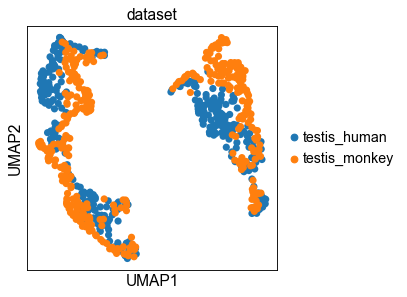

In [17]:
sc.set_figure_params(dpi_save=200)
sc.pp.neighbors(gadt, n_neighbors=15, metric='cosine', use_rep='X')


sc.tl.umap(gadt)
sc.pl.umap(gadt, color='dataset')

In [18]:
gadt1, gadt2 = pp.bisplit_adata(
    gadt, key='dataset', left_groups=dpair.dataset_names[:1],
    reset_index_by='name',
)
gadt1, gadt2

/Users/xingyan/.conda/envs/dgl/lib/python3.8/site-packages/anndata/_core/anndata.py:868: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['SPACA3', 'KTN1', 'SSX2IP', 'TXNDC2', 'TMEM239']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")
/Users/xingyan/.conda/envs/dgl/lib/python3.8/site-packages/anndata/_core/anndata.py:868: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['SPACA3', 'KTN1', 'SSX2IP', 'FAM81B', 'ENSMMUG00000003187']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")


(AnnData object with n_obs × n_vars = 348 × 128
     obs: 'name', 'dataset', 'is_linked', 'is_linked_1v1'
     uns: 'neighbors', 'umap', 'dataset_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 375 × 128
     obs: 'name', 'dataset', 'is_linked', 'is_linked_1v1'
     uns: 'neighbors', 'umap', 'dataset_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities')

Annotate TFs on UMAP-plots

In [19]:
figdir = came_resdir / 'figs'

# fig, axs = plt.subplots(1, 2)
_ = pl.umap_with_annotates(
    gadt1, text_ids=tfnames1, text_col='name',
#     ax=axs[0],
    fp=figdir / f'umap_with_tfs1.pdf',
)
_ = pl.umap_with_annotates(
    gadt2, text_ids=tfnames2, text_col='name',
#     ax=axs[1],
    fp=figdir / f'umap_with_tfs2.pdf',
)
# gadt1.obs

figure has been saved into:
	../_case_res/testis-('testis_human', 'testis_monkey')(08-01 00.01.46)/figs/umap_with_tfs1.pdf
figure has been saved into:
	../_case_res/testis-('testis_human', 'testis_monkey')(08-01 00.01.46)/figs/umap_with_tfs2.pdf
